In [ ]:
!pip install torch torch-geometric pandas numpy scikit-learn folium matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt

# Step 1: Mount Google Drive & Load Data
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
species_files = {
    2022: "/content/drive/MyDrive/2022年物种.csv",
    2023: "/content/drive/MyDrive/2023年物种.csv",
    2024: "/content/drive/MyDrive/2024年物种.csv"
}

nsb_files = {
    2022: "/content/drive/MyDrive/2022年光强.csv",
    2023: "/content/drive/MyDrive/2023年光强.csv",
    2024: "/content/drive/MyDrive/2024年光强.csv"
}

# Load and concatenate species data
dfs_species = []
for year, path in species_files.items():
    df = pd.read_csv(path)
    df['year'] = year
    dfs_species.append(df)

df_species = pd.concat(dfs_species, ignore_index=True)

# Load and concatenate light intensity (NSB) data
dfs_nsb = []
for year, path in nsb_files.items():
    df = pd.read_csv(path)
    df['year'] = year
    dfs_nsb.append(df)

df_nsb = pd.concat(dfs_nsb, ignore_index=True)

# Step 2: Round Coordinates (for spatial matching)
def round_coords(df):
    df['lat_round'] = df['latitude'].round(2)
    df['lon_round'] = df['longitude'].round(2)
    return df

df_species = round_coords(df_species)
df_nsb = round_coords(df_nsb)

# Step 3: Merge Species and NSB Data
merged_df = pd.merge(
    df_species,
    df_nsb[['month', 'lat_round', 'lon_round', 'nsb']],
    on=['month', 'lat_round', 'lon_round'],
    how='left'
)

# Step 4: KNN Imputation for Missing NSB Values
known = merged_df[~merged_df['nsb'].isna()][['lat_round', 'lon_round', 'nsb']]
unknown = merged_df[merged_df['nsb'].isna()][['lat_round', 'lon_round']]

if not known.empty and not unknown.empty:
    nbrs = NearestNeighbors(n_neighbors=1).fit(known[['lat_round', 'lon_round']])
    distances, indices = nbrs.kneighbors(unknown)
    merged_df.loc[merged_df['nsb'].isna(), 'nsb'] = known.iloc[indices.flatten()]['nsb'].values

# Step 5: Map gno to node_id
unique_gnos = merged_df['gno'].unique()
gno_to_node_id = {gno: idx for idx, gno in enumerate(unique_gnos)}
merged_df['node_id'] = merged_df['gno'].map(gno_to_node_id)

# Get unique node coordinates
unique_nodes = merged_df[['gno', 'latitude', 'longitude']].drop_duplicates().copy()
unique_nodes['node_id'] = unique_nodes['gno'].map(gno_to_node_id)
coords = unique_nodes[['latitude', 'longitude']].values
num_nodes = len(unique_nodes)

# Step 6: Build Time Series for Each Node
time_series_data = []
for gno in unique_gnos:
    sub_df = merged_df[merged_df['gno'] == gno].sort_values('month')
    time_series_data.append(sub_df[['nsb', 'latitude', 'longitude', 'count']].values)

# Check count distribution
all_counts = np.concatenate([ts[:, -1] for ts in time_series_data])
plt.figure(figsize=(8, 4))
plt.hist(all_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Count (Raw)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Step 7: Standardize All Features (including 'count')
# Concatenate all time series to build the scaler
all_features = np.concatenate(time_series_data, axis=0)

# Create and fit the scaler
scaler = StandardScaler()
scaler.fit(all_features)  # shape: [n_samples, n_features]

# Save the scaler to Google Drive
import joblib
joblib.dump(scaler, "/content/drive/MyDrive/scaler.pkl")
print("Scaler has been successfully saved to: /content/drive/MyDrive/scaler.pkl")

# Apply the scaler to each time series
for i in range(len(time_series_data)):
    time_series_data[i] = scaler.transform(time_series_data[i])

# Check count distribution after normalization
after_counts = np.concatenate([ts[:, -1] for ts in time_series_data])
plt.figure(figsize=(8, 4))
plt.hist(after_counts, bins=30, color='lightgreen', edgecolor='black')
plt.title("Distribution of Count (After Normalization)")
plt.xlabel("Normalized Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Step 8: Construct Sliding Window Samples
def create_windowed_samples(sequences, window=5):
    X, y = [], []
    for seq in sequences:
        if len(seq) < window + 1:
            continue  # Skip short sequences
        for i in range(len(seq) - window):
            X.append(seq[i:i+window])      # Shape: [window, num_features]
            y.append(seq[i+window, -1])     # Predict last feature (assumed to be 'count')
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Generate windowed samples
X_tensor, y_tensor = create_windowed_samples(time_series_data, window=5)

In [ ]:
# Step 9: Split into Training and Test Sets (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=True)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Step 10: Dynamic Graph Constructor
def build_temporal_graphs(coords):
    def get_graph():
        # Build adjacency matrix using k-nearest neighbors
        adj_matrix = kneighbors_graph(coords, n_neighbors=5, mode='connectivity')
        edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
        return Data(edge_index=edge_index)
    return get_graph

get_graph_func = build_temporal_graphs(coords)

# Step 11: Define the Model: GAT + LSTM + Dropout
class SpatialTemporalModel(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super().__init__()
        self.gat = GATConv(num_features, hidden_dim)  # Graph Attention Network
        self.dropout = nn.Dropout(0.3)                # Dropout for regularization
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)  # Temporal modeling
        self.fc = nn.Linear(hidden_dim, 1)            # Final output layer

    def forward(self, x_seq, get_graph_func):
        B, T, N, F = x_seq.shape  # Batch, Time steps, Nodes, Features
        outputs = []

        for t in range(T):
            x_t = x_seq[:, t]  # [B, N, F], input at time t
            graph = get_graph_func()
            edge_index = graph.edge_index

            # Create a list of PyG Data objects for each sample in the batch
            data_list = [Data(x=x_t[i], edge_index=edge_index) for i in range(B)]
            batch = Batch.from_data_list(data_list)

            # Apply GAT to capture spatial dependencies
            x = self.gat(batch.x, batch.edge_index)
            x = torch.relu(x)
            x = self.dropout(x)

            # Reshape and average node features across the graph
            x = x.view(B, N, -1).mean(dim=1)  # [B, H]
            outputs.append(x)

        # Stack outputs over time and apply LSTM
        x = torch.stack(outputs, dim=1)  # [B, T, H]
        x, _ = self.lstm(x)
        x = self.dropout(x)

        # Final prediction (last time step)
        return self.fc(x[:, -1])  # [B, 1]

In [ ]:
import matplotlib.pyplot as plt

# Step 12: Initialize Model & Start Training
model = SpatialTemporalModel(num_features=X_tensor.shape[-1], hidden_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
criterion = nn.MSELoss()

# Track training loss
train_losses = []

# Step 13: Training Loop + Visualization
print("Starting training...")
for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Expand to [B, T, N, F]
        B, T, F = X_batch.shape
        X_batch_expanded = X_batch.unsqueeze(2).expand(B, T, num_nodes, F)

        out = model(X_batch_expanded, get_graph_func)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss)
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# Step 14: Test Evaluation + Visualization
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch_expanded = X_batch.unsqueeze(2).expand(-1, -1, num_nodes, -1)
        out = model(X_batch_expanded, get_graph_func)
        test_preds.extend(out.squeeze().cpu().numpy())
        test_true.extend(y_batch.squeeze().cpu().numpy())

# Figure 1: Scatter plot of true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(test_true, test_preds, alpha=0.6)
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], color='red', linestyle='--')
plt.title("True vs Predicted Count (Test Set)")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.grid(True)
plt.show()

# Figure 2: Time series prediction example (first sample)
example_idx = 0
X_example = X_test[example_idx].unsqueeze(0)   # [1, T, F]
y_example = y_test[example_idx].item()

X_example_expanded = X_example.unsqueeze(2).expand(-1, -1, num_nodes, -1)
with torch.no_grad():
    pred = model(X_example_expanded, get_graph_func).item()

times = np.arange(X_example.shape[1])
plt.figure(figsize=(10, 5))
plt.plot(times, X_example[0, :, -1].cpu().numpy(), label="Historical Count", marker='o')
plt.plot(times[-1]+1, y_example, 'ro', markersize=10, label="True Future")
plt.plot(times[-1]+1, pred, 'go', markersize=10, label="Predicted Future")
plt.title("Time Series Prediction Example")
plt.xlabel("Time Step")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# Step 15: Save Model to Google Drive
# Define model save path
model_save_path = '/content/drive/MyDrive/nsb_prediction.pth'

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model has been successfully saved to: {model_save_path}")

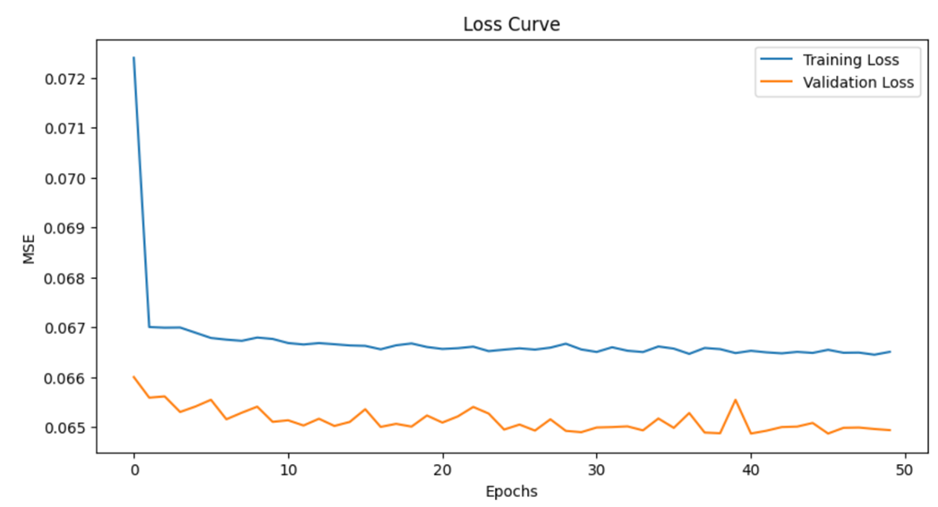

Use the model to do some predictions. (用 2024香港光强数据来预测 2024香港物种分布）

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv

# Step 1: Load Light Intensity Data for 2024
nsb_2024_path = '/content/drive/MyDrive/2024年光强.csv'
df_nsb_2024 = pd.read_csv(nsb_2024_path)

# Round coordinates to facilitate matching
def round_coords(df):
    df['lat_round'] = df['latitude'].round(2)
    df['lon_round'] = df['longitude'].round(2)
    return df

df_nsb_2024 = round_coords(df_nsb_2024)

# Step 2: Build Node ID Mapping
unique_locations = df_nsb_2024[['latitude', 'longitude']].drop_duplicates()
gno_to_node_id = {tuple(row): idx for idx, row in enumerate(unique_locations.values)}
df_nsb_2024['node_id'] = df_nsb_2024.apply(lambda row: gno_to_node_id[(row['latitude'], row['longitude'])], axis=1)

# Step 3: Build Time Series
time_series_data_2024 = []
for _, group in df_nsb_2024.groupby(['latitude', 'longitude']):
    sorted_group = group.sort_values('month')
    time_series_data_2024.append(sorted_group[['nsb', 'latitude', 'longitude']].values)

# Step 4: Load Scaler and Apply Standardization
import joblib
scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")  # Assume you saved this during training

# Standardize all sequences using the previously fitted scaler
standardized_sequences = []
for seq in time_series_data_2024:
    standardized_seq = scaler.transform(seq)
    standardized_sequences.append(standardized_seq)

# Step 5: Create Sliding Window Samples
def create_windowed_samples(sequences, window=5):
    X = []
    for seq in sequences:
        if len(seq) < window:
            continue
        for i in range(len(seq) - window + 1):
            X.append(seq[i:i+window])  # [window, F]
    return torch.tensor(np.array(X), dtype=torch.float32)

X_tensor_2024 = create_windowed_samples(standardized_sequences, window=5)

# Wrap into DataLoader
dataset_2024 = TensorDataset(X_tensor_2024)
loader_2024 = DataLoader(dataset_2024, batch_size=8)

# Step 6: Load Trained Model
class SpatialTemporalModel(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super().__init__()
        self.gat = GATConv(num_features, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x_seq, get_graph_func):
        B, T, N, F = x_seq.shape
        outputs = []

        for t in range(T):
            x_t = x_seq[:, t]  # [B, N, F]
            graph = get_graph_func()
            edge_index = graph.edge_index

            data_list = [Data(x=x_t[i], edge_index=edge_index) for i in range(B)]
            batch = Batch.from_data_list(data_list)

            x = self.gat(batch.x, batch.edge_index)
            x = torch.relu(x)
            x = self.dropout(x)
            x = x.view(B, N, -1).mean(dim=1)  # [B, H]
            outputs.append(x)

        x = torch.stack(outputs, dim=1)  # [B, T, H]
        x, _ = self.lstm(x)
        x = self.dropout(x)
        return self.fc(x[:, -1])  # [B, 1]

# Load model weights
model_save_path = '/content/drive/MyDrive/nsb_prediction.pth'
model = SpatialTemporalModel(num_features=X_tensor.shape[-1], hidden_dim=32)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Step 7: Dynamic Graph Constructor
def build_temporal_graphs(coords):
    def get_graph():
        # Build adjacency matrix using k-nearest neighbors
        adj_matrix = kneighbors_graph(coords, n_neighbors=5, mode='connectivity')
        edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
        return Data(edge_index=edge_index)
    return get_graph

get_graph_func = build_temporal_graphs(coords)

#  Step 8: Perform Prediction
all_predictions = []

with torch.no_grad():
    for X_batch in loader_2024:
        X_batch_expanded = X_batch[0].unsqueeze(2).expand(-1, -1, num_nodes, -1)
        out = model(X_batch_expanded, get_graph_func)
        all_predictions.extend(out.squeeze().cpu().numpy())

# Inverse transform predictions using the same scaler
pred_unscaled = []
for pred in all_predictions:
    dummy_row = np.zeros((1, scaler.n_features_in_))  # Create a zero array
    dummy_row[0, -1] = pred  # Replace last column with predicted count
    unscaled = scaler.inverse_transform(dummy_row)[0, -1]
    pred_unscaled.append(unscaled)

#  Step 9: Construct Result DataFrame
# Extract location info from the last window per location
last_month_per_location = []
for _, group in df_nsb_2024.groupby(['latitude', 'longitude']):
    if len(group) >= 5:
        last_month_per_location.append(group.iloc[-1])

result_df = pd.DataFrame(last_month_per_location)
result_df.reset_index(drop=True, inplace=True)
result_df['predicted_count'] = pred_unscaled

# Save prediction results
result_df.to_csv("/content/drive/MyDrive/predicted_count_2024.csv", index=False)

# Display sample results
print("Preview of prediction results:")
print(result_df[['latitude', 'longitude', 'month', 'predicted_count']])

原始输入形状: torch.Size([5, 4])
滚动预测结果: [0.06173516437411308, -0.0071622878313064575, 0.07934410870075226, -0.005438994616270065, -0.0062591321766376495]


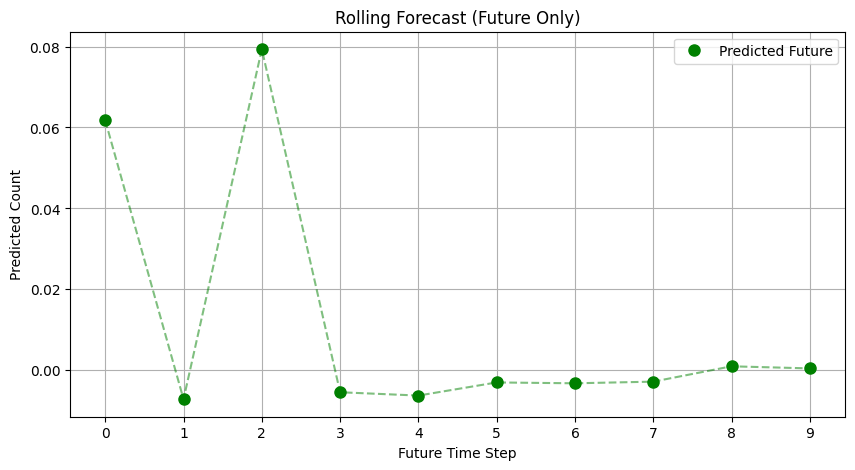

In [ ]:
# Step 2: Load Scaler
scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")

# Step 3: Define Model Structure (same as training)
class SpatialTemporalModel(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super().__init__()
        self.gat = GATConv(num_features, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x_seq, get_graph_func):
        B, T, N, F = x_seq.shape
        outputs = []

        for t in range(T):
            x_t = x_seq[:, t]  # [B, N, F]
            graph = get_graph_func()
            edge_index = graph.edge_index

            data_list = [Data(x=x_t[i], edge_index=edge_index) for i in range(B)]
            batch = Batch.from_data_list(data_list)

            x = self.gat(batch.x, batch.edge_index)
            x = torch.relu(x)
            x = self.dropout(x)
            x = x.view(B, N, -1).mean(dim=1)  # [B, H]
            outputs.append(x)

        x = torch.stack(outputs, dim=1)  # [B, T, H]
        x, _ = self.lstm(x)
        x = self.dropout(x)
        return self.fc(x[:, -1])  # [B, 1]

# Step 4: Build Dynamic Graph Function
def rolling_forecast(model, initial_window, steps=5, num_nodes=num_nodes):

    predictions = []
    current_window = initial_window.clone()  # shape: [T, F]

    for step in range(steps):
        # Expand to [B=1, T, N, F]
        with torch.no_grad():
            expanded_input = current_window.unsqueeze(0).unsqueeze(2).expand(1, -1, num_nodes, -1)
            pred = model(expanded_input, get_graph_func).item()
        predictions.append(pred)

        # Construct new row: copy last row and update count feature
        new_entry = current_window[-1].clone()
        new_entry[-1] = pred  # Replace last feature (count)

        # Update window: remove first row and add new row at the end
        current_window = torch.cat([current_window[1:], new_entry.unsqueeze(0)], dim=0)

    return predictions

# Example usage:
example_idx = 0
X_example = X_tensor[example_idx]  # shape: [window, features]

# Assume original data is [window, features], e.g., [5, 4]
print("Original input shape:", X_example.shape)  # Should output: torch.Size([5, 4])

# Call rolling forecast function
preds_roll = rolling_forecast(model, X_example, steps=5)
print("Rolling forecast results:", preds_roll)

# Step 7: Execute Testing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example: Rolling forecast for a single sample
example_idx = 0
X_example = X_tensor[example_idx]  # shape: [window, features]
y_example = y_tensor[example_idx].item()

# Perform rolling forecast (predict next 5 steps)
preds_roll = rolling_forecast(model, X_example, steps=20)

# Visualization of rolling forecast results
times = np.arange(X_example.shape[0])
# Only show future prediction
plt.figure(figsize=(10, 5))

# Use index starting from 0 to represent future time steps
future_steps = np.arange(len(preds_roll))

# Plot all predicted points
for i, p in enumerate(preds_roll):
    plt.plot(future_steps[i], p, 'go', markersize=8, label="Predicted Future" if i == 0 else "")


# Optional: Connect prediction points with line
plt.plot(future_steps, preds_roll, 'g--', alpha=0.5)

# Set chart labels
plt.title("Rolling Forecast (Future Only)")
plt.xlabel("Future Time Step")
plt.ylabel("Predicted Count")
plt.xticks(future_steps)
plt.legend()
plt.grid(True)
plt.show()
